## Cifar 100 Convolutional Neural Network Implementation

This work contains the implementation of two kind of Neural Networks (AlexNet and a Custom model based in LeeNet and AlexNet), validating their capacity to classify the CIFAR10 dataset, a set of images that contains 10 different classes.

In [7]:
# Pytorch Imports #
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler

# Torchvision Imports #
import torchvision.datasets as datasets
import torchvision.transforms as T

# matplotlib imports #
import matplotlib.pyplot as plt

# numpy imports #
import numpy as np

### Import Libraries needed for Google Drive mount

In [ ]:
# Library installaation using pip for linux backend of colab#
!pip install -U -q PyDrive

# Import of Libraries from Drive using google collab api #
import os

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

from google.colab import drive
from google.colab import auth

from oauth2client.client import GoogleCredentials

### <u>Function used to Download data from Drive</u> :

In [ ]:
# Function for downloading especific Data from the Drive folders #
def download_Data(file_list, string_Discriminator):
  # Check inside the folder if is already downlaoded #
  downloaded = []

  for path in os.scandir("/content/"):
    downloaded.append(path.name)

  # Iterate through the files and download them to the data folder if not already downloaded, and are of the givne extension type#
  for files in file_list:
    if (string_Discriminator in files['title']) & (files['title'] not in downloaded):
      print('title: %s, id: %s' % (files['title'], files['id']))
      fname = os.path.join(local_download_path, files['title'])
      print('downloading to {}'.format(fname))
      f_ = drive.CreateFile({'id': files['id']})
      f_.GetContentFile(fname)
      downloaded.append(fname)

### Import Files from Drive

In [ ]:
from google.colab import drive

#Authentication and creation the PyDrive client.
auth.authenticate_user()   #See if credentials are valid
gauth = GoogleAuth()       #Start the authentication of the collab
gauth.credentials = GoogleCredentials.get_application_default()
drive.mount("/content/gdrive")  #Mounts drive in the collab to save the important data
drive = GoogleDrive(gauth) #Finishes the authentication

#Choose a local directory inside the colab to import the data.
local_download_path = os.path.expanduser('/content')

# Try to make the directories in the colab #
try:
  os.makedirs(local_download_path)
except: pass

#Iterate through items using the query syntax for google drive
#https://developers.google.com/drive/v2/web/search-parameters

# Create a file list based on the query syntax searching in our drive folder and download it#
file_list = drive.ListFile(
    {'q': "'1cE1xy17xLMl_OGifP0Ech5xilZe53ptp' in parents"}).GetList()

# Download only files from these types from Drive folder 1sqEm5Pvxcg2X2yF2jkZKoojJmSXpysXe #
download_Data(file_list,".pt")

### Import User Functions

In [8]:
# User files Imports #
from models.alexNet import CNN_AlexNet
from models.resNet import ResNet9

from utils.dataset_utils import cifar100_dataset_Generator, verify_data, cifar100_dataset_statistics
from utils.general_utils import get_available_devices, set_all_seeds
from utils.matplotlib_utils import plot_figure, plot_figures_grid, plot_minibatch_loss, plot_accuracy_epochs, plot_confusion_matrix, plot_model_outputs
from utils.models_utils import train_cnn, load_model, save_model, compute_total_accuracy, compute_confusion_matrix, get_integrated_gradient, get_occlusion, get_convolutional_layer_weights, get_outputs

## Cuda Verification

In [9]:
device = get_available_devices()

NVIDIA GeForce GTX 1660 Ti


### Set initial Seed for Neural Network
Allows us to shuffle the model in the same way if we want to get the same initial weights with a Re-Run

In [10]:
set_all_seeds(0)

### Configure Dataset

We need to prepare the data for the different models training, so the data is transformed using the next parameters:

- AlexNet Image Dimensions: Original - 32 x 32 x 3, Augmented to 72x72, rotated by 15 degrees max, horizontally flipped, cropped back to - 64 x 64 x 3, and normalized with dataset mean and standard diviation.
- ResNet9 Image Dimensions: Original - 32 x 32 x 3, Augmented to 48x48, rotated by 15 degrees max, horizontally flipped, cropped back to - 32 x 32 x 3, and normalized with dataset mean and standard diviation.
- Training Dataset samples - 50000
- Validation Dataset samples - 10000
- Test Dataset samples - 10000
- Minibatch size - 64
- Erasing of pixels - Probability: 0.05, Scale of Erased portion: 0.05, 0.1, Colors Erased: random

Using this augmentation technics we can augmentate the number of images in the dataset, making them different than the original set. This way the networks can train without overfitting the model. In this case the data is not normalized, but the distribution of the clases inside of the dataloaders are evenly distributed. 

In [11]:
# Dataset Configuration #
MINIBATCH_SIZE = 128
DOWNLOAD = True
LOG = True

# Dataset Transformation Tensor using CIFAR 100 Normalized standar #
transform_cifar = T.Compose([T.ToTensor(),
                             T.Resize((72, 72)),
                             T.RandomRotation(15),
                             T.RandomHorizontalFlip(),
                             T.RandomCrop(64, padding=4,padding_mode='reflect'), 
                             T.RandomErasing(0.05,(0.05,0.1),value="random"),
                             T.Normalize(*cifar100_dataset_statistics(),inplace=True)
                             ])

train_data_loader_alexNet, validation_data_loader_alexNet, test_data_loader_alexNet = cifar100_dataset_Generator(transform_cifar,MINIBATCH_SIZE,DOWNLOAD,LOG)

# Dataset Transformation Tensor using CIFAR 100 Normalized standar #
transform_cifar = T.Compose([T.ToTensor(),
                             T.Resize((48, 48)),
                             T.RandomRotation(15),
                             T.RandomHorizontalFlip(),
                             T.RandomCrop(32, padding=4,padding_mode='reflect'), 
                             T.RandomErasing(0.05,(0.05,0.1),value="random"),
                             T.Normalize(*cifar100_dataset_statistics(),inplace=True)
                             ])

train_data_loader_resNet, validation_data_loader_resNet, test_data_loader_resNet = cifar100_dataset_Generator(transform_cifar,MINIBATCH_SIZE,DOWNLOAD,LOG)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./Cifar100_Data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(72, 72), interpolation=bilinear, max_size=None, antialias=warn)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(64, 64), padding=4)
               RandomErasing(p=0.05, scale=(0.05, 0.1), ratio=(0.3, 3.3), value=random, inplace=False)
               Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343], std=[0.26733428587941854, 0.25643846292120615, 0.2761504713263903])
           )


Dataset CIFAR100
    Number of datapoints: 10000
    Root location: ./Cifar100_Data
    Split: Test
    StandardTra

### Verification of Dataloaders

In [12]:
verify_data(train_data_loader_alexNet.dataset, train_data_loader_alexNet.dataset, train_data_loader_alexNet.dataset)

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./Cifar100_Data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(72, 72), interpolation=bilinear, max_size=None, antialias=warn)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(64, 64), padding=4)
               RandomErasing(p=0.05, scale=(0.05, 0.1), ratio=(0.3, 3.3), value=random, inplace=False)
               Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343], std=[0.26733428587941854, 0.25643846292120615, 0.2761504713263903])
           )
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./Cifar100_Data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(72, 72), interpolation=bilinear, max_size=None, antialias=warn)
        

In [13]:
verify_data(train_data_loader_resNet.dataset, train_data_loader_resNet.dataset, train_data_loader_resNet.dataset)

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./Cifar100_Data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(48, 48), interpolation=bilinear, max_size=None, antialias=warn)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(32, 32), padding=4)
               RandomErasing(p=0.05, scale=(0.05, 0.1), ratio=(0.3, 3.3), value=random, inplace=False)
               Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343], std=[0.26733428587941854, 0.25643846292120615, 0.2761504713263903])
           )
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./Cifar100_Data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(48, 48), interpolation=bilinear, max_size=None, antialias=warn)
        

### Show Single Image

The image Class is: chimpanzee


C:\Users\oswy2\Documents\Redes_Neuronales\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


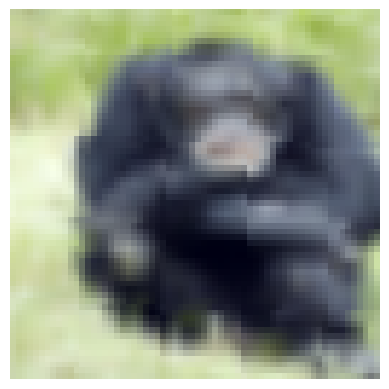

In [14]:
plot_figure(train_data_loader_alexNet)

### Show Multiple Images

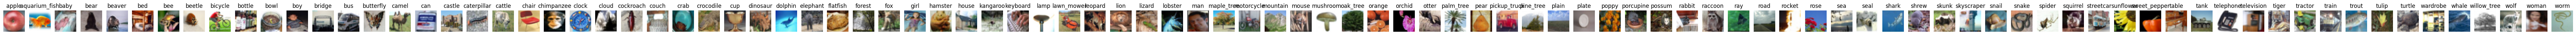

In [42]:
plot_figures_grid(train_data_loader_alexNet,samples=1,gridsize=[100,100])

### AlexNet Paper Model

References

[1] Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." In Advances in Neural Information Processing Systems, pp. 1097-1105. 2012.

- This model has an architecture with maxpooling and dropout, with the next hyperparameters.
- Learning Rate: 0.002
- Epochs: 30
- Minibatch: 128
- Optimizer: Adams
- Scheduler: OneCycleLR

### Neural Network AlexNet Model Implementation

In [64]:
# Hyperparameters Definitions
LEARNING_RATE = 0.002
NUM_EPOCHS = 30

# Architecture
NUM_CLASSES = 100

# Model extension save
Model_NAME = "alexNet.pt"

# Create model using AlexNet class
alexNet_model = CNN_AlexNet(NUM_CLASSES)

# Send Device to GPU  if available
alexNet_model.to(device)

# Optimizer implementation - Adam
optimizer = torch.optim.Adam(alexNet_model.parameters(), lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)

# Scheduler  #
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, LEARNING_RATE, epochs=NUM_EPOCHS, steps_per_epoch=len(train_data_loader_alexNet))

### Training of Network

In [ ]:
logger = train_cnn(NUM_EPOCHS,alexNet_model,optimizer,scheduler,device,train_data_loader_alexNet,validation_data_loader_alexNet)

### Save Network Model in drive

In [66]:
save_model(alexNet_model,Model_NAME)
save_model(optimizer, "optimizer_" + Model_NAME)

### Evaluation of Model

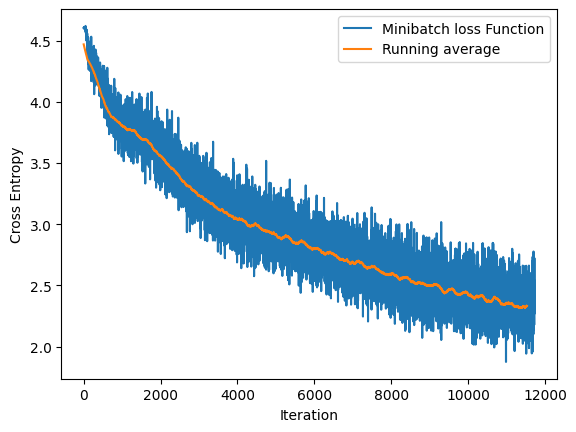

In [67]:
plot_minibatch_loss(logger,"train_loss_batch")

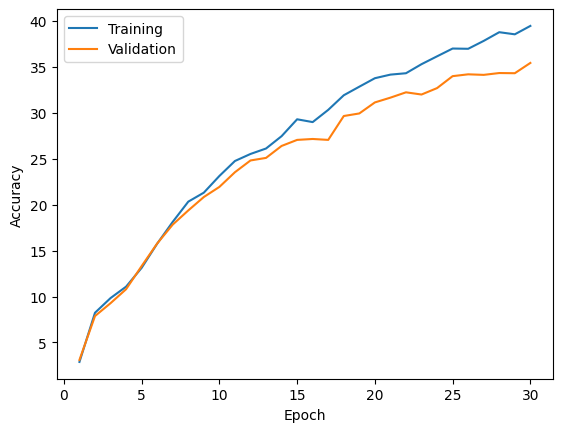

In [68]:
plot_accuracy_epochs(logger,NUM_EPOCHS,["train_accuracy_epoch","validation_accuracy_epoch"])

### Graphs Explanations

- We can see that the loss function has an uneven behavior, but the average is an stable descending curve, meaning the model is training.
- We can see that the accuracy per epoch slows down drastically after a few epochs, this could be attributed to the depth of the model and how it trains to the given data or to the scale of the dataset. 
- We can see that the validation accuracy and the training accuracy slowly grows without stalling, so with more epochs and a better gpu for training is possible that the model can get a decen accuracy for both datasets

### Neural Network ResNet9 Model Implementation

References

[2] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition."Microsoft Research. 2015.

- This model has an architecture containing rest layers and have been trained with the next hyperparameters.
- Learning Rate: 0.001
- Weight Decae 0.001
- Epochs: 50
- Minibatch: 128
- Optimizer: Adams
- Scheduler: OneCycleLR

In [15]:
# Hyperparameters Definitions
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
WEIGHT_DECAY = 0.001

# Architecture
NUM_CLASSES = 100

# Model extension save
Model_NAME = "resnet.pt"

# Create model using AlexNet class
resnet_model = ResNet9(3,NUM_CLASSES)

resnet_model.to(device)

# Optimizer implementation - Adam
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)

# Scheduler  #
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, LEARNING_RATE, epochs=NUM_EPOCHS, steps_per_epoch=len(train_data_loader_resNet))

### Evaluation of Model

In [ ]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.0001, epochs=10, steps_per_epoch=len(train_data_loader_resNet))
logger = train_cnn(10,resnet_model,optimizer,scheduler,device,train_data_loader_resNet,validation_data_loader_resNet)

Epoch: 001/010 | Batch 0000/0391 | Loss: 0.9056
Epoch: 001/010 | Batch 0064/0391 | Loss: 0.6490
Epoch: 001/010 | Batch 0128/0391 | Loss: 0.6265
Epoch: 001/010 | Batch 0192/0391 | Loss: 0.6584
Epoch: 001/010 | Batch 0256/0391 | Loss: 0.5353
Epoch: 001/010 | Batch 0320/0391 | Loss: 0.8730
Epoch: 001/010 | Batch 0384/0391 | Loss: 0.6772
***Epoch: 001/010 | Train. Acc.: 82.772% | Loss: 0.628
***Epoch: 001/010 | Valid. Acc.: 59.100% | Loss: 1.568
Time elapsed: 7.97 min
Epoch: 002/010 | Batch 0000/0391 | Loss: 0.5317
Epoch: 002/010 | Batch 0064/0391 | Loss: 0.5080
Epoch: 002/010 | Batch 0128/0391 | Loss: 0.7306
Epoch: 002/010 | Batch 0192/0391 | Loss: 0.7018
Epoch: 002/010 | Batch 0256/0391 | Loss: 0.8616
Epoch: 002/010 | Batch 0320/0391 | Loss: 0.6962
Epoch: 002/010 | Batch 0384/0391 | Loss: 0.7146
***Epoch: 002/010 | Train. Acc.: 83.632% | Loss: 0.596
***Epoch: 002/010 | Valid. Acc.: 59.360% | Loss: 1.587
Time elapsed: 17.23 min
Epoch: 003/010 | Batch 0000/0391 | Loss: 0.4718
Epoch: 003/01

In [28]:
log_tmp["train_loss_batch"].extend(logger["train_loss_batch"])
log_tmp["train_loss_epoch"].extend(logger["train_loss_epoch"])
log_tmp["train_accuracy_epoch"].extend(logger["train_accuracy_epoch"])
log_tmp["validation_loss_epoch"].extend(logger["validation_loss_epoch"])
log_tmp["validation_accuracy_epoch"].extend(logger["validation_accuracy_epoch"])

### Save Network Model in drive

In [29]:
save_model(resnet_model, Model_NAME)
save_model(optimizer, "optimizer_" + Model_NAME)

### Evaluation of Model

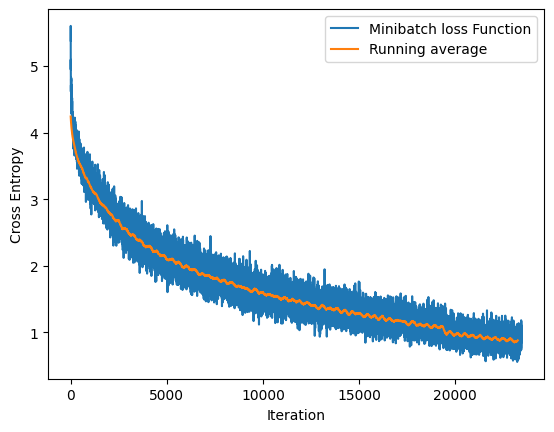

In [31]:
plot_minibatch_loss(log_tmp,"train_loss_batch")

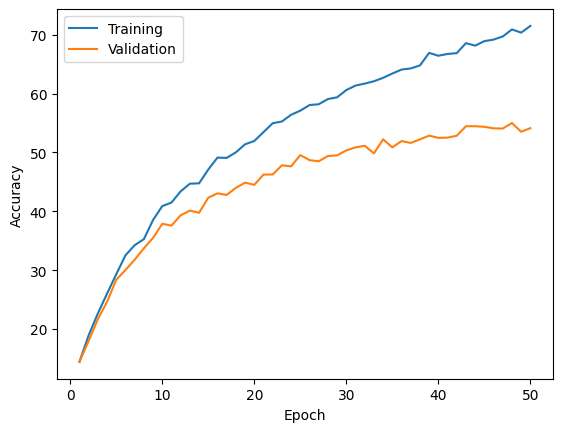

In [19]:
plot_accuracy_epochs(logger,NUM_EPOCHS,["train_accuracy_epoch","validation_accuracy_epoch"])

### Graphs Explanations
- We can see that the loss function have an stable descending curve, mening that the model is accurately training with the data provided.
- The accuracy per epoch starts ramping up in the first 10 epochs, and slows down form that point, even if the training validation is so high it does not seems like the model is overfitting to the dataset, beacause the validation accuracy is not settled by that point. Even if the slope is small the model is still improving its accuracy. With other tweaks in the Transformation its possible to obtain more than 70% percent of accuracy, but it will require more time training.